## Univariate time series prediction with energy consumption data
In this example, we will be solving a problem of the domain of regression. 
For this reason we will build a multi layer RNN with two LSTMs.
The type of regression we will do is of the "Many to one" type, because the network will receive a sequence of energy consumption values, and will try to output the next value, based on the previous 4 registers.

The dataset we will be working on is a compendium of many measurements of power consumption of one
home, throughout a period of time. As we could infer, this kind of behaviour can easily
follow patterns (It increases when the persons uses the microwave to prepare breakfast, and
computers after the wake up hour, can decrease a bit in the afternoon, and then increase at
night with all the lights, decreasing to zero starting from midnight until next wake up
hour). So let's try to model for this behavior in a sample case.

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


## Dataset description and loading
In this example we will be using the Electricity Load Diagrams Data Sets, from Artur Trindade
(site: https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014).
This is the description of the original dataset:

Data set has no missing values.
Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
Each column represent one client. Some clients were created after 2011. In these cases
consumption were considered zero.
All time labels report to Portuguese hour. However all days present 96 measures (24*15).
Every year in March time change day (which has only 23 hours) the values between 1:00
am and 2:00 am are zero for all points. Every year in October time change day (which has
25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two
hours.


In order to simplify our model description, we took just one client complete measurements,
and converted its format to standard CSV. It is located on the data subfolder of this chapter
code folder.

So we will load the first 1500 values of the consumption of a sample home of the dataset.

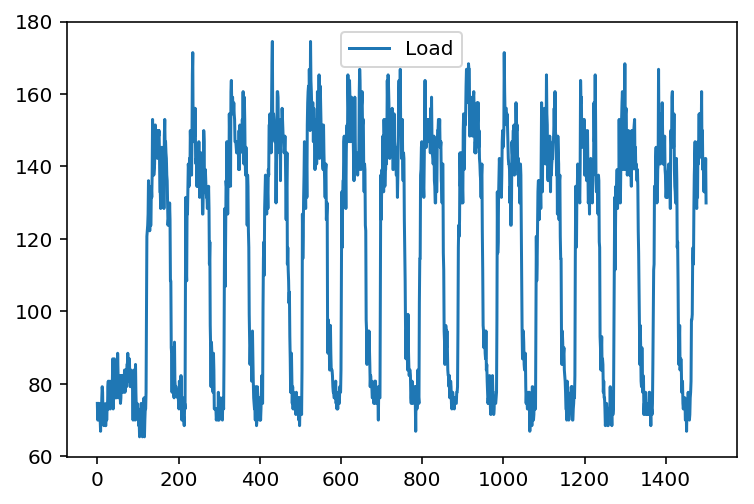

In [2]:
df = pd.read_csv("data/elec_load.csv", error_bad_lines=False)
plt.subplot()
plot_test, = plt.plot(df.values[:1500], label='Load')
plt.legend(handles=[plot_test])

If we take a look at this representation (We look to the first 1500 samples) we see an initial
transient state, probably when the measurements were put in place, and then we see a really
clear cycle of high and low consumption levels.
From simple observation we also see that the cicles are more or less of 100 samples, pretty
close to the 96 samples per day this dataset has.

### Dataset preprocessing
In order to assure a better convergency of the back propagation methods, we should try to
normalize the input data.
So we will be applying the classic scale and centering technique, substracting the mean
value, and scaling by the floor of the maximum value.
To get the needed values, we use the pandas' describe() method.

                Load
count  140256.000000
mean      145.332503
std        48.477976
min         0.000000
25%       106.850998
50%       151.428571
75%       177.557604
max       338.218126


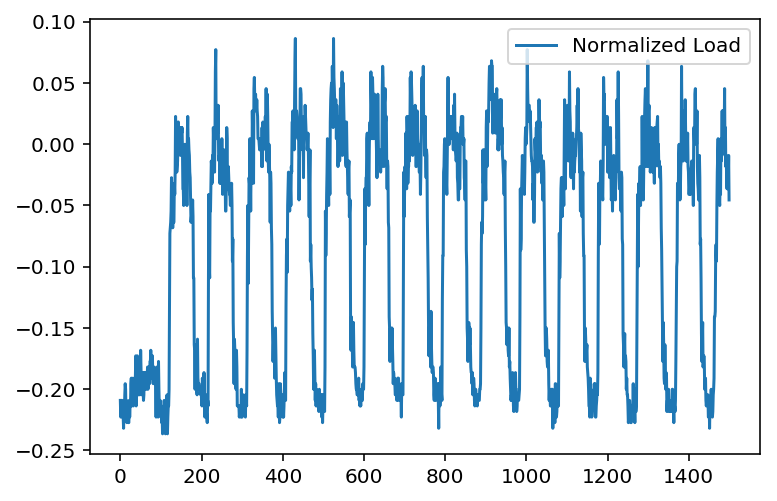

In [3]:
print(df.describe())
array=(df.values - 145.33) /338.21
plt.subplot()
plot_test, = plt.plot(array[:1500], label='Normalized Load')
plt.legend(handles=[plot_test])

In this step we will prepare our input dataset, because we need an input x [Previous 5 values], with a corresponding input y [value after 5 timesteps]
Then we will assign the first 13000 elements to the train set, and then we will assign the following 1000 samples to the testig set.

In [4]:
listX = []
listy = []
X={}
y={}

for i in range(0,len(array)-6):
    listX.append(array[i:i+5].reshape([5,1]))
    listy.append(array[i+6])

arrayX=np.array(listX)
arrayy=np.array(listy)

X['train']=arrayX[0:13000]
X['test']=arrayX[13000:14000]

y['train']=arrayy[0:13000]
y['test']=arrayy[13000:14000]

Now we will build the model, which will be a dual LSTM, with a dropout layer at the end of each. Additionally, we will add a dense layer at the end, and a linear activation final unit, to obtain a single float prediction.
After that, we save a representation of the model in an image.

In [5]:
#Build the model
model = Sequential()

model.add(LSTM( units=50, input_shape=(None, 1), return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM( units=200, input_shape=(None, 100), return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation("linear"))

model.compile(loss="mse", optimizer="rmsprop")  

Now it's time to run the model and adjust the weights. The model fitter will use 8% of the dataset values as the validation set.

In [6]:
#Fit the model to the data

model.fit(X['train'], y['train'], batch_size=512, epochs=100, validation_split=0.08)

Train on 11960 samples, validate on 1040 samples
Epoch 1/100
11960/11960 [==============================] - 2s 140us/step - loss: 0.0032 - val_loss: 0.0020
Epoch 2/100
11960/11960 [==============================] - 0s 22us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 3/100
11960/11960 [==============================] - 0s 22us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/100
11960/11960 [==============================] - 0s 21us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/100
11960/11960 [==============================] - 0s 21us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/100
11960/11960 [==============================] - 0s 23us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/100
11960/11960 [==============================] - 0s 27us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/100
11960/11960 [==============================] - 0s 28us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/100
11960/11960 [==============================] - 0s 26us/step - loss: 0.0013 - val_loss: 0.0

Epoch 77/100
11960/11960 [==============================] - 0s 22us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 78/100
11960/11960 [==============================] - 0s 22us/step - loss: 0.0010 - val_loss: 9.8988e-04
Epoch 79/100
11960/11960 [==============================] - 0s 22us/step - loss: 0.0010 - val_loss: 9.9358e-04
Epoch 80/100
11960/11960 [==============================] - 0s 22us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 81/100
11960/11960 [==============================] - 0s 23us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 82/100
11960/11960 [==============================] - 0s 22us/step - loss: 0.0010 - val_loss: 9.8843e-04
Epoch 83/100
11960/11960 [==============================] - 0s 22us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 84/100
11960/11960 [==============================] - 0s 23us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 85/100
11960/11960 [==============================] - 0s 24us/step - loss: 0.0010 - val_loss: 9.9767e-04
Epoch 86/100
11960/11

After rescaling , it's time to see how our model predicts the values, compared with the actual test values, which didn't participate in the training of the models, to understand how the model is able to generalize the behavior of the sample home.

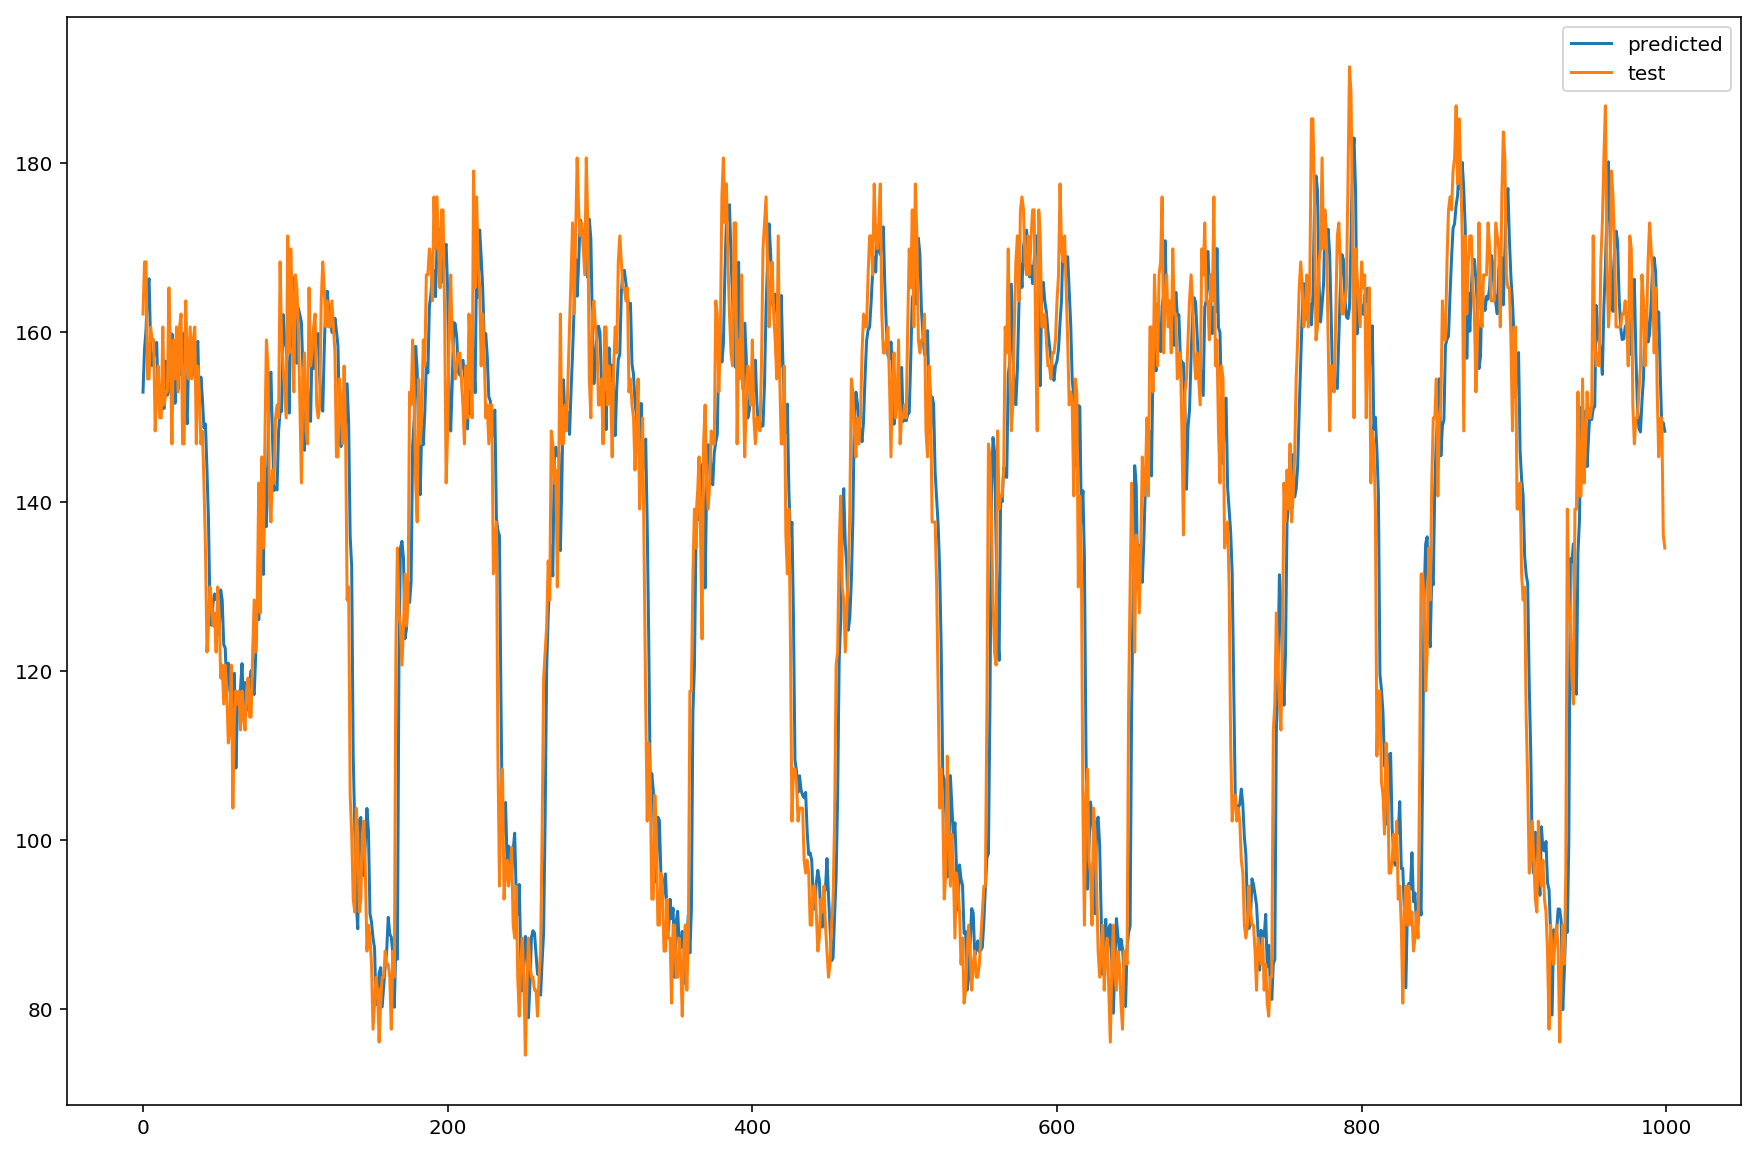

In [7]:
# Rescale the test dataset and predicted data

test_results = model.predict( X['test'])

test_results = test_results * 338.21 + 145.33
y['test'] = y['test'] * 338.21 + 145.33

plt.figure(figsize=(15,10))
plot_predicted, = plt.plot(test_results, label='predicted')

plot_test, = plt.plot(y['test']  , label='test');
plt.legend(handles=[plot_predicted, plot_test]);
plt.savefig("fig.jpg")
plt.show()